In [1]:
# analyse results and determind how many proteins in pdb database have phrog annotations

** Updated version 2025-04-08*** using mmseqs easy search

In [1]:
# imports 
import pandas as pd
import re
from collections import Counter
import requests
import seaborn as sns
import pickle
from itertools import chain
import matplotlib.pyplot as plt

### Look at the lengths of the PHROG representative sequences 

In [2]:
phrog_lengths = pd.read_csv('/home/grig0076/scratch/phlegm/PHROGs/nonsingleton_representative_sequences.lengths.txt', sep = ' ', header = None)
phrog_lengths[0] = [p[1:] for p in phrog_lengths[0]]

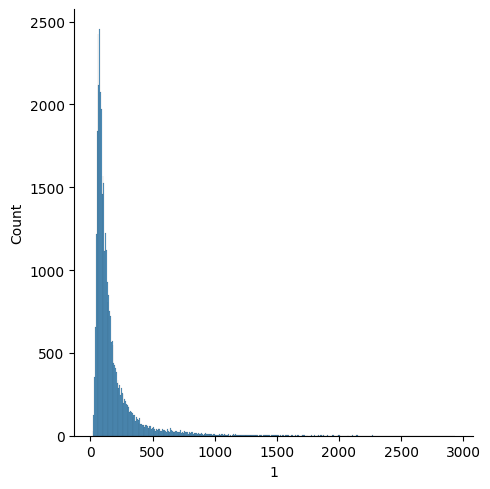

In [3]:
sns.displot(phrog_lengths[1]) # some sequences will be pretty big to fold 

Plot the distribution of the sequence lengths

In [4]:
# read in all the information needing 
oligomer_predictions = pickle.load(open('/home/grig0076/scratch/phlegm/all_pdb/pharokka/pdb_oligomeric_states_mmseqs2_2025-04-08.pkl', 'rb')) 

# add deposition date to the dataframe 
date_dict = dict(zip(oligomer_predictions.keys(), [oligomer_predictions.get(i).get('Deposition_Date') for i in list(oligomer_predictions.keys())]))
states = [str(set([j[0] for j in list(i.get('Assemblies').values())]))[2:-2] for i in oligomer_predictions.values()]
state_dict = dict(zip(oligomer_predictions.keys(), states)) 

In [5]:
from Bio import SeqIO
import pandas as pd

# Load the m8 file
#df = pd.read_csv("/home/grig0076/scratch/phlegm/PHROGs/phrog_represenative_pdb_seqres_minseqid0.3_c0.4.m8", sep="\t", header=None)
df = pd.read_csv("/home/grig0076/scratch/phlegm/PHROGs/phrog_represenative_pdb_seqres_minseqid0.3_c0.7.m8", sep="\t", header=None)
df.columns = [
    "query", "target", "pident", "alnlen", "mismatch", "gapopen",
    "qstart", "qend", "tstart", "tend", "evalue", "bitscore"
]

# Load query and target lengths from FASTA files
def load_lengths(fasta_file):
    return {record.id: len(record.seq) for record in SeqIO.parse(fasta_file, "fasta")}

query_lengths = load_lengths("/home/grig0076/scratch/phlegm/PHROGs/nonsingleton_representative_sequences.fasta")
target_lengths = load_lengths("/home/grig0076/scratch/phlegm/all_pdb/pdb_seqres.cleaned.txt")

# Map lengths to dataframe
df["qlen"] = df["query"].map(query_lengths)
df["tlen"] = df["target"].map(target_lengths)

# Compute coverage
df["query_coverage"] = (df["qend"] - df["qstart"] + 1) / df["qlen"]
df["target_coverage"] = (df["tend"] - df["tstart"] + 1) / df["tlen"]
df['pdb'] = [re.split('_',i)[0] for i in df['target']]

df['Deposition_Date'] = [date_dict.get(i) for i in df['pdb']]
df['oligomeric_state'] = [state_dict.get(i) for i in df['pdb']]

# filter out heteromeric hits 
df = df[~df['oligomeric_state'].str.contains('Hetero')]

#if one entry has two states and one is a monomer then remove the monomer entry 
reformat_states = [] 

for o in df['oligomeric_state']: 
    
    if ',' in o and 'Monomer' in o:
        o = o.replace("Monomer', '", '')
        o = o.replace("', 'Monomer", '')
    reformat_states.append(o)
        
df['oligomeric_state'] = reformat_states

In [6]:
# go through phrog entries to interpret 
phrogs = list(set(df['query']))
oligomeric_rate = pd.DataFrame() 
cutoff_date = pd.Timestamp("2021-09-30", tz="UTC")

counts = 0 
for p in phrogs: 
    
    # get the hits for this phrog
    this_phrog_hits = df[df['query'] == p]
    
    # get the oligomeric states associated with this phrog
    states = this_phrog_hits[['pdb', 'oligomeric_state']].drop_duplicates()['oligomeric_state']
    state_rate = pd.DataFrame.from_dict(Counter(states), orient = 'index')/len(states) 
    state_rate.columns = [p]
    state_rate.loc['_num_assemblies'] = len(states)
    
    # get the deposition dates
    dates = pd.to_datetime(this_phrog_hits['Deposition_Date'], errors='coerce') 
    contains_training = False 
    if (dates < cutoff_date).any():
        contains_training = True
    state_rate.loc['contains_training'] = contains_training
    
    # update the dataframe 
    oligomeric_rate = pd.concat([state_rate, oligomeric_rate], axis=1).fillna(0)
    
    
    #counts+=1
    #if counts ==8: 
        
        # drop duplicates from the same pdb id 
    #    break
    #print(Counter(this_phrog_hits['oligomeric_state']))
    
# update with the predict state and its rate 
oligomeric_rate.loc['best_rate'] = oligomeric_rate.drop(['contains_training', '_num_assemblies']).max(axis=0)
oligomeric_rate.loc['best_state'] = oligomeric_rate.drop(['contains_training', '_num_assemblies']).idxmax(axis=0)
    
# reverse orientation because I like it more 
oligomeric_rate = oligomeric_rate.T

In [7]:
oligomeric_rate

,Homo 2-mer,_num_assemblies,contains_training,Homo 4-mer,Homo 6-mer,"Homo 2-mer', 'Homo 6-mer","Homo 3-mer', 'Homo 6-mer",Monomer,Homo 3-mer,Homo 12-mer,...,"Homo 3-mer', 'Homo 24-mer","Homo 10-mer', 'Homo 2-mer","Homo 4-mer', 'Homo 2-mer', 'Homo 12-mer","Homo 4-mer', 'Homo 2-mer', 'Homo 6-mer","Homo 3-mer', 'Homo 4-mer","Homo 9-mer', 'Homo 18-mer","Homo 15-mer', 'Homo 8-mer",Homo 235-mer,best_rate,best_state
phrog_26417,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Homo 2-mer
phrog_242,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Homo 2-mer
phrog_34154,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Homo 2-mer
phrog_9148,0.382353,34.0,1.0,0.058824,0.470588,0.058824,0.029412,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.470588,Homo 6-mer
phrog_20167,0.130435,23.0,1.0,0.0,0.0,0.0,0.0,0.73913,0.043478,0.086957,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.73913,Monomer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
phrog_18103,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Monomer
phrog_5979,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Monomer
phrog_315,0.5,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,Homo 2-mer
phrog_28373,0.0,16.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Monomer


In [8]:
oligomeric_rate[oligomeric_rate['contains_training'] == 1]

,Homo 2-mer,_num_assemblies,contains_training,Homo 4-mer,Homo 6-mer,"Homo 2-mer', 'Homo 6-mer","Homo 3-mer', 'Homo 6-mer",Monomer,Homo 3-mer,Homo 12-mer,...,"Homo 3-mer', 'Homo 24-mer","Homo 10-mer', 'Homo 2-mer","Homo 4-mer', 'Homo 2-mer', 'Homo 12-mer","Homo 4-mer', 'Homo 2-mer', 'Homo 6-mer","Homo 3-mer', 'Homo 4-mer","Homo 9-mer', 'Homo 18-mer","Homo 15-mer', 'Homo 8-mer",Homo 235-mer,best_rate,best_state
phrog_26417,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Homo 2-mer
phrog_242,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Homo 2-mer
phrog_34154,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Homo 2-mer
phrog_9148,0.382353,34.0,1.0,0.058824,0.470588,0.058824,0.029412,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.470588,Homo 6-mer
phrog_20167,0.130435,23.0,1.0,0.0,0.0,0.0,0.0,0.73913,0.043478,0.086957,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.73913,Monomer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
phrog_18103,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Monomer
phrog_5979,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Monomer
phrog_315,0.5,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,Homo 2-mer
phrog_28373,0.0,16.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Monomer


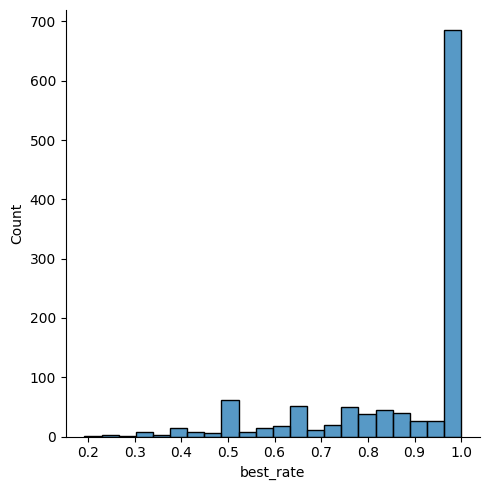

In [9]:
# plot the rates 
sns.displot(oligomeric_rate[oligomeric_rate['contains_training'] == 1]['best_rate']) # this shows that the rate is normally agreed with 

## Phrogs that do not contain training data 

In [10]:
validation_phrogs= oligomeric_rate[oligomeric_rate['contains_training'] == 0]  
validation_phrogs.sort_values('_num_assemblies')

,Homo 2-mer,_num_assemblies,contains_training,Homo 4-mer,Homo 6-mer,"Homo 2-mer', 'Homo 6-mer","Homo 3-mer', 'Homo 6-mer",Monomer,Homo 3-mer,Homo 12-mer,...,"Homo 3-mer', 'Homo 24-mer","Homo 10-mer', 'Homo 2-mer","Homo 4-mer', 'Homo 2-mer', 'Homo 12-mer","Homo 4-mer', 'Homo 2-mer', 'Homo 6-mer","Homo 3-mer', 'Homo 4-mer","Homo 9-mer', 'Homo 18-mer","Homo 15-mer', 'Homo 8-mer",Homo 235-mer,best_rate,best_state
phrog_252,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Homo 60-mer
phrog_16914,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Homo 3-mer
phrog_866,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Monomer
phrog_3767,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Homo 2-mer
phrog_1856,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Homo 2-mer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
phrog_6215,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Monomer
phrog_7951,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Homo 2-mer
phrog_506,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Monomer
phrog_1048,0.090909,11.0,0.0,0.818182,0.0,0.0,0.0,0.090909,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.818182,Homo 4-mer


In [13]:
validation_state_counts = pd.DataFrame.from_dict(Counter(validation_phrogs['best_state']), orient='index')
validation_state_counts_include = validation_state_counts[validation_state_counts.index.isin(['Homo 2-mer', 'Homo 3-mer', 'Monomer', 'Homo 6-mer',
       'Homo 4-mer', 'Homo 9-mer', 'Homo 12-mer',
        'Homo 10-mer',
       'Homo 5-mer', 'Homo 8-mer'])]
validation_state_counts_include

,0
Homo 4-mer,8
Homo 3-mer,19
Monomer,28
Homo 6-mer,8
Homo 2-mer,23
Homo 12-mer,7
Homo 9-mer,1
Homo 10-mer,1
Homo 5-mer,1


In [18]:
# get the phrogs with valid state
validation_phrogs_valid = validation_phrogs[validation_phrogs['best_state'].isin(['Homo 2-mer', 'Homo 3-mer', 'Monomer', 'Homo 6-mer',
       'Homo 4-mer', 'Homo 9-mer', 'Homo 12-mer',
        'Homo 10-mer',
       'Homo 5-mer', 'Homo 8-mer'])]

In [20]:
validation_phrogs_valid['best_state']

phrog_16743     Homo 4-mer
phrog_9502      Homo 3-mer
phrog_8702         Monomer
phrog_12132     Homo 3-mer
phrog_4197         Monomer
                  ...     
phrog_21       Homo 12-mer
phrog_6215         Monomer
phrog_14847     Homo 6-mer
phrog_30120     Homo 2-mer
phrog_1856      Homo 2-mer
Name: best_state, Length: 96, dtype: object

In [ ]:
# save these phrog ids and their oligomeric state to a text file 